https://en.wikipedia.org/wiki/Fibonacci_word_fractal

Prompt: generate Fibonacci word fractal code (reference: https://en.wikipedia.org/wiki/Fibonacci_word_fractal) and plots, also generate code to look at the fractal dimension and show this as part of the output

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/fibonacci_word_fractal_order20.png'

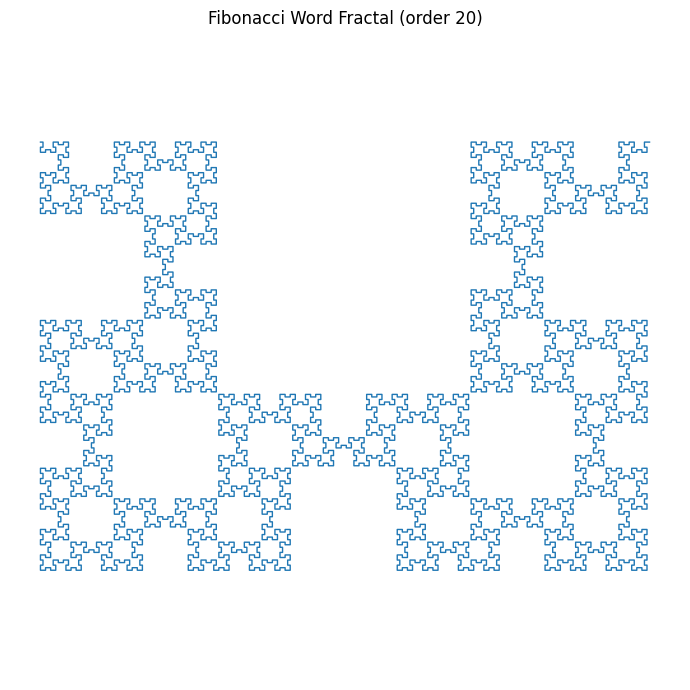

In [11]:
# Fibonacci word fractal: generation, plotting, and fractal-dimension (box-counting) estimate
#
# Notes:
# - Uses the "odd-even drawing rule" from the Fibonacci word fractal definition.
# - Draws the curve and estimates its fractal (box-counting) dimension from sampled points.
# - Change `ORDER` to refine the curve. Higher orders grow exponentially, so start modestly.
#
# Charts:
# 1) The curve itself.
# 2) Log–log plot of box-counting N(ε) vs 1/ε with fitted slope = estimated dimension.
#
# This notebook saves figures to /mnt/data so you can download them.

import numpy as np
import matplotlib.pyplot as plt

# ------------------ Parameters ------------------
ORDER = 20           # Fibonacci word order (e.g., 18–22 are reasonable; too big -> heavy)
STEP  = 1.0          # Step length (kept at 1.0; scaling doesn't change dimension)
ANGLE_DEG = 90.0     # Turning angle (Fibonacci word fractal uses 90°)


# ------------------ Fibonacci word ------------------
def fibonacci_word(n: int) -> str:
    """
    Returns the nth Fibonacci word using concatenation:
      F1 = "1", F2 = "0", Fn = F(n-1) + F(n-2).
    The infinite limit begins 0100101001001...
    """
    if n == 0:
        return "0"
    if n == 1:
        return "01"
    a, b = "0", "01"
    for _ in range(2, n+1):
        a, b = b, b + a
    return b

# ------------------ Build polyline by odd-even drawing rule ------------------
def fib_word_curve_points(word: str, step: float = 1.0, angle_deg: float = 90.0):
    """
    Given a Fibonacci word, produce the polyline vertices by:
      - For each symbol at position k (1-indexed):
         * Move forward by 'step' along current heading
         * If symbol is '0':
             - if k even: turn left by angle_deg
             - if k odd:  turn right by angle_deg
         * If symbol is '1': no turn
    Returns an (N+1, 2) array of xy vertices (including starting point).
    """
    theta = 0.0  # initial heading (radians); arbitrary orientation
    ct, st = np.cos(np.deg2rad(theta)), np.sin(np.deg2rad(theta))
    # start at origin
    x, y = 0.0, 0.0
    pts = [(x, y)]
    ang = np.deg2rad(angle_deg)
    for i, ch in enumerate(word, start=1):
        # forward move
        x += step * np.cos(theta)
        y += step * np.sin(theta)
        pts.append((x, y))
        # turning rule for '0'
        if ch == '0':
            if (i % 2) == 0:   # even -> left
                theta += ang
            else:              # odd  -> right
                theta -= ang
        # '1' -> no turn
    return np.array(pts, dtype=float)

# ------------------ Box-counting on sampled points ------------------
def box_count_dimension_from_points(pts: np.ndarray, min_boxes: int = 8, drop_edges: int = 1):
    """
    Estimate box-counting dimension using integer binning of point coordinates.
    Approach:
      - Affine-rescale to integer grid with unit lattice spacing (preserving topology).
      - For box sizes ε_k = 2^k (in pixel units), count occupied boxes via unique indices.
      - Fit slope of log N(ε) vs log(1/ε).
    Args:
      pts: (M,2) array of polyline vertices. We'll densely sample unit steps between vertices.
      min_boxes: ensure the smallest ε is such that at least this many boxes span the max-range.
      drop_edges: drop this many smallest and largest scales from regression to reduce bias.
    Returns:
      eps_sizes, counts, slope (dimension), intercept
    """
    # Densify along axis-aligned unit steps (the curve is axis-aligned)
    # Build lattice points visited after each step.
    # Since our polyline was created with unit-length steps, pts already enumerates unit steps.
    # We'll use integer rounding after recentering so bins align.
    x = pts[:,0]
    y = pts[:,1]
    # Shift to positive and round to integer lattice
    xmin, ymin = x.min(), y.min()
    X = np.rint(x - xmin).astype(np.int64)
    Y = np.rint(y - ymin).astype(np.int64)

    # Compute span extents
    width  = int(X.max() - X.min() + 1)
    height = int(Y.max() - Y.min() + 1)
    L = max(width, height)

    # Choose box sizes as powers of two up to span
    # Ensure at least a handful of scales
    max_pow = int(np.floor(np.log2(L))) if L > 1 else 1
    powers = np.arange(0, max_pow + 1, dtype=int)
    eps = 2 ** powers  # box sizes (pixels)

    # Drop very large boxes that exceed span in both directions (still fine, they yield N~1)
    # For robustness we keep all, but will trim edges for regression.
    N_eps = []
    for e in eps:
        if e <= 0:
            continue
        # Box indices for each lattice point
        i = X // e
        j = Y // e
        # Count occupied boxes by unique (i,j) pairs
        # Pack into one 1D key to speed up uniqueness
        key = i.astype(np.int64) * (L + 1) + j.astype(np.int64)
        n_boxes = np.unique(key).size
        N_eps.append(n_boxes)
    N_eps = np.array(N_eps, dtype=float)

    # Prepare x,y for regression: log N versus log(1/ε)
    xlog = np.log(1.0 / eps.astype(float))
    ylog = np.log(N_eps)

    # Trim edges to mitigate finite-size effects
    sl = slice(drop_edges, len(eps) - drop_edges) if len(eps) > 2*drop_edges else slice(0, len(eps))
    coeffs = np.polyfit(xlog[sl], ylog[sl], 1)
    slope, intercept = coeffs[0], coeffs[1]
    return eps.astype(float), N_eps, slope, intercept, xlog, ylog, sl

# ------------------ Run everything ------------------
word = fibonacci_word(ORDER)
pts = fib_word_curve_points(word, step=STEP, angle_deg=ANGLE_DEG)

# Plot the curve
fig1 = plt.figure(figsize=(7, 7))
plt.plot(pts[:,0], pts[:,1], linewidth=1.0)
plt.axis('equal')
plt.axis('off')
plt.title(f"Fibonacci Word Fractal (order {ORDER})")
fig1.tight_layout()
curve_path = "/mnt/data/fibonacci_word_fractal_order{}.png".format(ORDER)
fig1.savefig(curve_path, dpi=200, bbox_inches='tight')
plt.show()

# Estimate box-counting dimension
eps, N_eps, dim_est, intercept, xlog, ylog, sl = box_count_dimension_from_points(pts, drop_edges=2)

# Plot log–log + fitted line
fig2 = plt.figure(figsize=(7, 5))
plt.plot(np.log(1.0/eps), np.log(N_eps), marker='o', linestyle='')
# Fitted line across regression range
xfit = xlog[sl]
yfit = dim_est * xfit + intercept
plt.plot(xfit, yfit, linewidth=1.5)
plt.xlabel("log(1/ε)")
plt.ylabel("log N(ε)")
plt.title(f"Box-counting estimate: D ≈ {dim_est:.4f}")
fig2.tight_layout()
boxcount_path = "/mnt/data/fibonacci_word_boxcount_order{}.png".format(ORDER)
fig2.savefig(boxcount_path, dpi=200, bbox_inches='tight')
plt.show()

# Print results and reference value
phi = (1 + 5 ** 0.5) / 2.0
theoretical_D = 3.0 * np.log(phi) / np.log(1.0 + np.sqrt(2.0))
frontier_D = np.log(3.0) / np.log(1.0 + np.sqrt(2.0))

print(f"Order: {ORDER}, #segments: {len(word)}")
print(f"Estimated box-counting dimension (curve): D ≈ {dim_est:.4f}")
print(f"Theoretical Hausdorff dimension (curve):  D = 3 log(phi) / log(1+sqrt(2)) ≈ {theoretical_D:.4f}")
print(f"Theoretical dimension (frontier):         D_frontier = log(3)/log(1+sqrt(2)) ≈ {frontier_D:.4f}")
print()
print("Saved figures:")
print(curve_path)
print(boxcount_path)
